In [146]:
import yfinance as yf
import pandas as pd
import os

In [147]:
if os.path.exists("sp500.csv"):
    sp500 = pd.read_csv("sp500.csv", index_col=0)
else:
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history(period="max")
    sp500.to_csv("sp500.csv")

In [148]:
sp500.index = pd.to_datetime(sp500.index)

/var/folders/_9/gvwygmmj7mn8j8w4btg7nt0r0000gn/T/ipykernel_99078/318495744.py:1: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  sp500.index = pd.to_datetime(sp500.index)


In [149]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-05-31 00:00:00-04:00,5243.209961,5280.330078,5191.680176,5277.509766,5437160000,0.0,0.0
2024-06-03 00:00:00-04:00,5297.149902,5302.109863,5234.319824,5283.399902,4046920000,0.0,0.0
2024-06-04 00:00:00-04:00,5278.240234,5298.799805,5257.629883,5291.339844,3707900000,0.0,0.0


<Axes: xlabel='Date'>

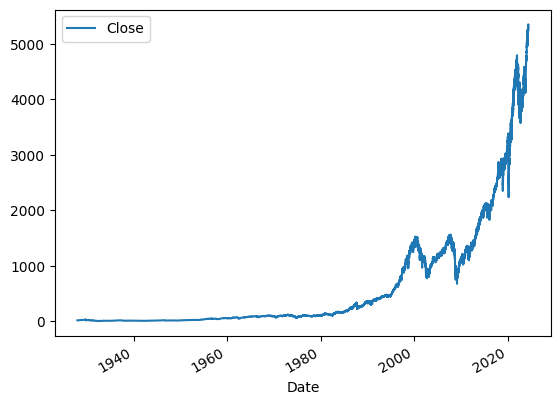

In [150]:
sp500.plot.line(y="Close", use_index=True)

In [151]:
del sp500["Dividends"]
del sp500["Stock Splits"]

In [152]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [153]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [154]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [155]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

1.0

<Axes: xlabel='Date'>

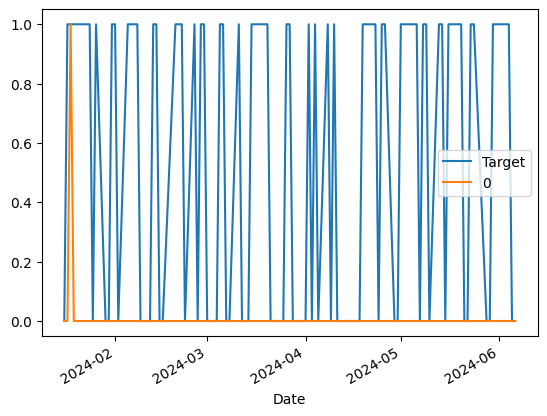

In [156]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [157]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [158]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [159]:
predictions = backtest(sp500, model, predictors)

In [160]:
predictions["Predictions"].value_counts()

Predictions
0    12291
1     9433
Name: count, dtype: int64

In [161]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5166967030637125

In [162]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.52633
0    0.47367
Name: count, dtype: float64

In [163]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [164]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])

In [165]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1931-12-29 00:00:00-05:00,7.960000,7.960000,7.960000,7.960000,0,8.100000,1,1.012723,1.0,0.996994,3.0,0.821282,24.0,0.582074,105.0,0.394305,521.0
1931-12-30 00:00:00-05:00,8.100000,8.100000,8.100000,8.100000,0,8.120000,1,1.008717,2.0,1.019381,3.0,0.837787,25.0,0.593657,105.0,0.401432,521.0
1931-12-31 00:00:00-05:00,8.120000,8.120000,8.120000,8.120000,0,7.560000,0,1.001233,2.0,1.017544,4.0,0.842149,25.0,0.596489,105.0,0.402615,522.0
1932-01-04 00:00:00-05:00,7.560000,7.560000,7.560000,7.560000,0,7.550000,0,0.964286,1.0,0.956962,3.0,0.785781,25.0,0.556754,104.0,0.375034,522.0
1932-01-05 00:00:00-05:00,7.550000,7.550000,7.550000,7.550000,0,8.080000,1,0.999338,0.0,0.960804,3.0,0.787963,24.0,0.557255,104.0,0.374726,521.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31 00:00:00-04:00,5243.209961,5280.330078,5191.680176,5277.509766,5437160000,5283.399902,1,1.003998,1.0,0.999881,3.0,1.019448,31.0,1.120875,139.0,1.259004,530.0
2024-06-03 00:00:00-04:00,5297.149902,5302.109863,5234.319824,5283.399902,4046920000,5291.339844,1,1.000558,2.0,1.001806,3.0,1.020172,31.0,1.121164,140.0,1.259724,531.0
2024-06-04 00:00:00-04:00,5278.240234,5298.799805,5257.629883,5291.339844,3707900000,5354.029785,1,1.000751,2.0,1.003871,3.0,1.021154,32.0,1.121890,140.0,1.260941,531.0


In [166]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [167]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [168]:
predictions = backtest(sp500, model, new_predictors)

In [169]:
predictions["Predictions"].value_counts()

Predictions
0.0    17556
1.0     3168
Name: count, dtype: int64

In [170]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5965909090909091

In [171]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.529
0    0.471
Name: count, dtype: float64

In [172]:
predictions

,Target,Predictions
Date,,
1942-01-07 00:00:00-05:00,0,0.0
1942-01-08 00:00:00-05:00,0,0.0
1942-01-09 00:00:00-05:00,0,0.0
1942-01-12 00:00:00-05:00,1,0.0
1942-01-13 00:00:00-05:00,0,0.0
...,...,...
2024-05-31 00:00:00-04:00,1,1.0
2024-06-03 00:00:00-04:00,1,0.0
2024-06-04 00:00:00-04:00,1,0.0
